# Evaluation of model error with test set 

Using the best-trained model, let's evaluate its performance comparing the predictions and real values for the test set,  using the following measurements:
- The R2-score
- Mean Absolute error  
- Mean Absolute Deviation

The values on the train set are also estimated to compare the model performance

In [1]:
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor
from utils import *

df_hour = pd.read_csv("hour.csv")

In [2]:
# adding 3h and 1w features
names = []
for i,name in [ (3,"3h") ,(24*7,"1w")]:
    %%time df_hour[name]= df_hour["instant"].apply(lambda x: aggregate_last_n_hours(df_hour,x,i)  )
    names.append(name)

Wall time: 1.52 s
Wall time: 1min 33s


In [3]:
preliminary_features = ["season","mnth","hr","holiday","weekday","workingday","weathersit","temp","hum","windspeed","cnt"]
df = df_hour[ preliminary_features + names ]

In [4]:
#encoding categorical
categorical2encode = ["season","mnth","hr","weekday","weathersit"]
df = one_hot_encode(df,categorical2encode)

Number of model features after one-hot encoding: 58


In [5]:
# train test split
X_train, y_train, X_test, y_test = split_train_test(df,fraction_train=0.8)

In [6]:
# scaling 1w and 3h using MinMaxScaler fitted to training data. Test data not used to avoide leakage 
scalers = {}
for name in ["3h","1w"]:
    scaler = MinMaxScaler()
    feature_name = name+"_scaled"
    X_train[feature_name]=scaler.fit_transform( X_train[name].values.reshape(-1, 1) )   
    X_train = X_train.drop(columns=name)
    scalers[name] = scaler

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
# definning split for forward-validation
n_splits=5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [8]:
model = ElasticNet(max_iter=3000,tol=1e-5)
# training and hyper-parameter optimization:
##sub-space of hyper-parameters:
parameters = {'alpha':[1e-3,5e-3,1e-2,5e-2,1e-1,1,5], 'l1_ratio':[0.05,0.25,0.5,0.75,1.0]}
clf_agg = GridSearchCV(model, parameters, cv=tscv,scoring="r2",n_jobs=-1)
%time clf_agg.fit(X_train,y_train)

Wall time: 28.7 s


c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=3000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=1e-05, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5], 'l1_ratio': [0.05, 0.25, 0.5, 0.75, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [9]:
#transforming test set for predictions
for name in ["3h","1w"]:
    feature_name = name+"_scaled"
    X_test[feature_name] = scalers[name].transform( X_test[name].values.reshape(-1, 1) )   
    X_test= X_test.drop(columns=name)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


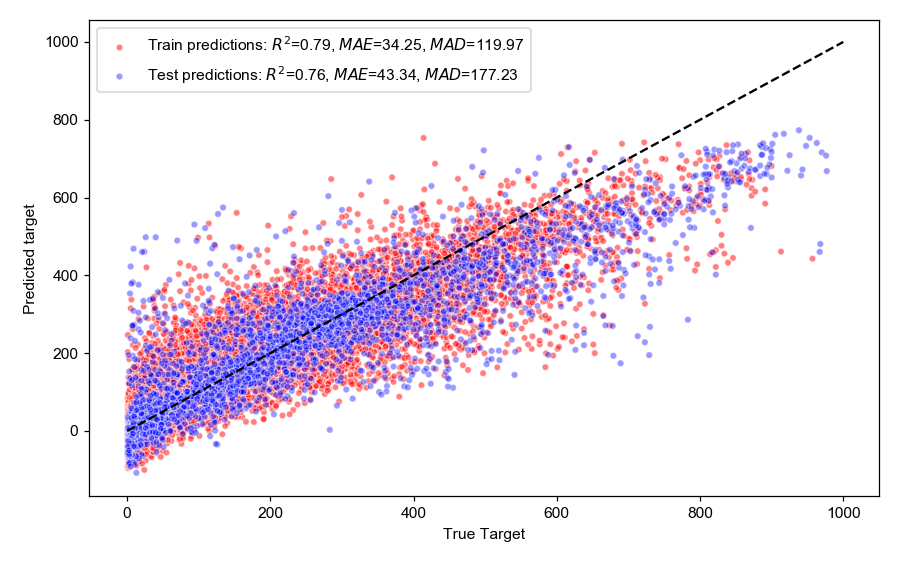

In [10]:
y_train_pred = clf_agg.predict(X_train) 
y_test_pred = clf_agg.predict(X_test)
saveplot="error_on_test_set"
compare_predictions_vs_true(y_train_pred,y_train,y_test_pred,y_test)#,saveplot)

## Prediction interval for model 

In a regression problem one does not predict a precise value but rather an interval with some probability that the real outcome is within such range. 

For a gaussian(-like) distributed data, a prediction interval with confidence 95% is the range of values with 2\*$\sigma$ around the predicted outcome, e.g.  $y_{pred} \pm 2*\sigma $. (z-score)

If the developed model is a good representation of the data one expects small residuals between predicted and true values,  with a distribution centered around zero, having small std dev. and being approximately independent of the true value.

Let's check the residuals distribution for the test set:

<IPython.core.display.Javascript object>


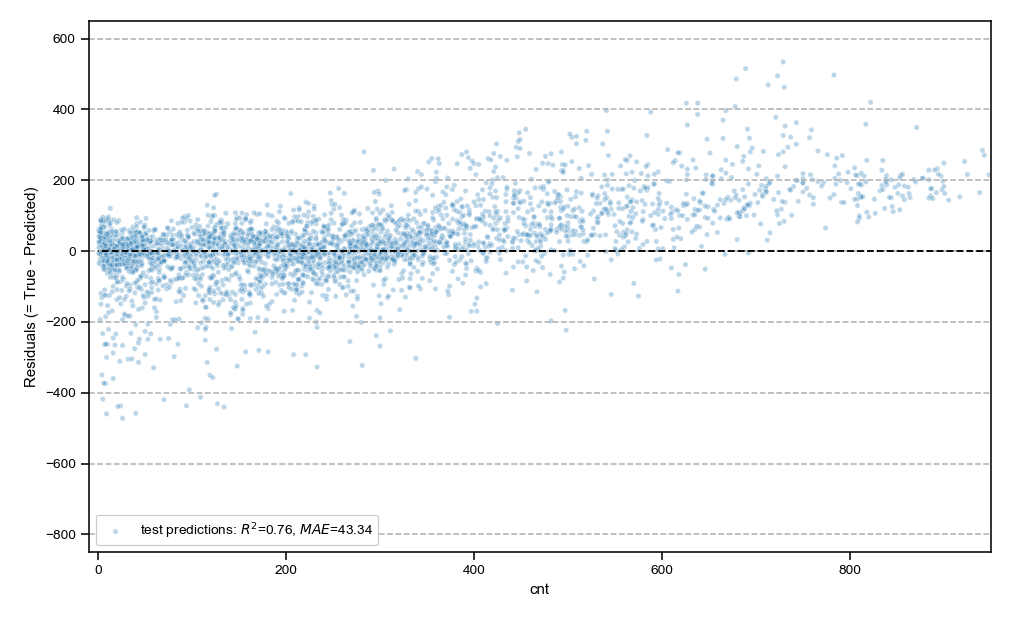

In [11]:
sns.set_context("paper")
residuals_predictions = plot_residuals(y_test,{"test predictions":y_test_pred}, saveplot="")

<IPython.core.display.Javascript object>


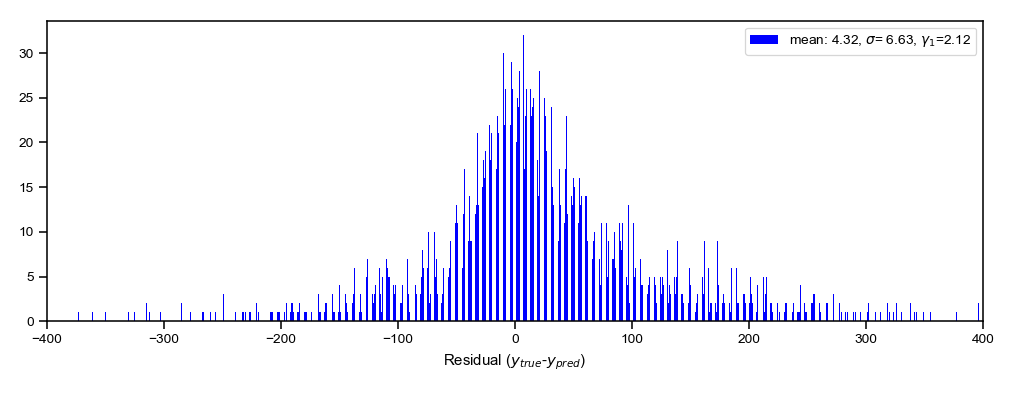

In [12]:
bin_cnts = residuals_distribution(residuals_predictions)

One can see several things:

- There is some dependence between the value of `cnt` and the ($y_{true}$-$y_{pred}$). This suggest a that the target is not fully represented by a linear model, so either one can find a suitable transformation of `cnt` or one develop more sophisticated features (maybe polynomial features).

- The mean of the residuals distribution is not precisely zero but nevertheless a small value close.
- $\sigma$ is relatively high in comparison to the mean
- The skewnewss $\gamma_1$ is rather large (actually equal to the lognormal or exp distributions), so providing confidence intervals for gaussian-like distributions is not the mos appropiate.

### Feature Importance

<IPython.core.display.Javascript object>


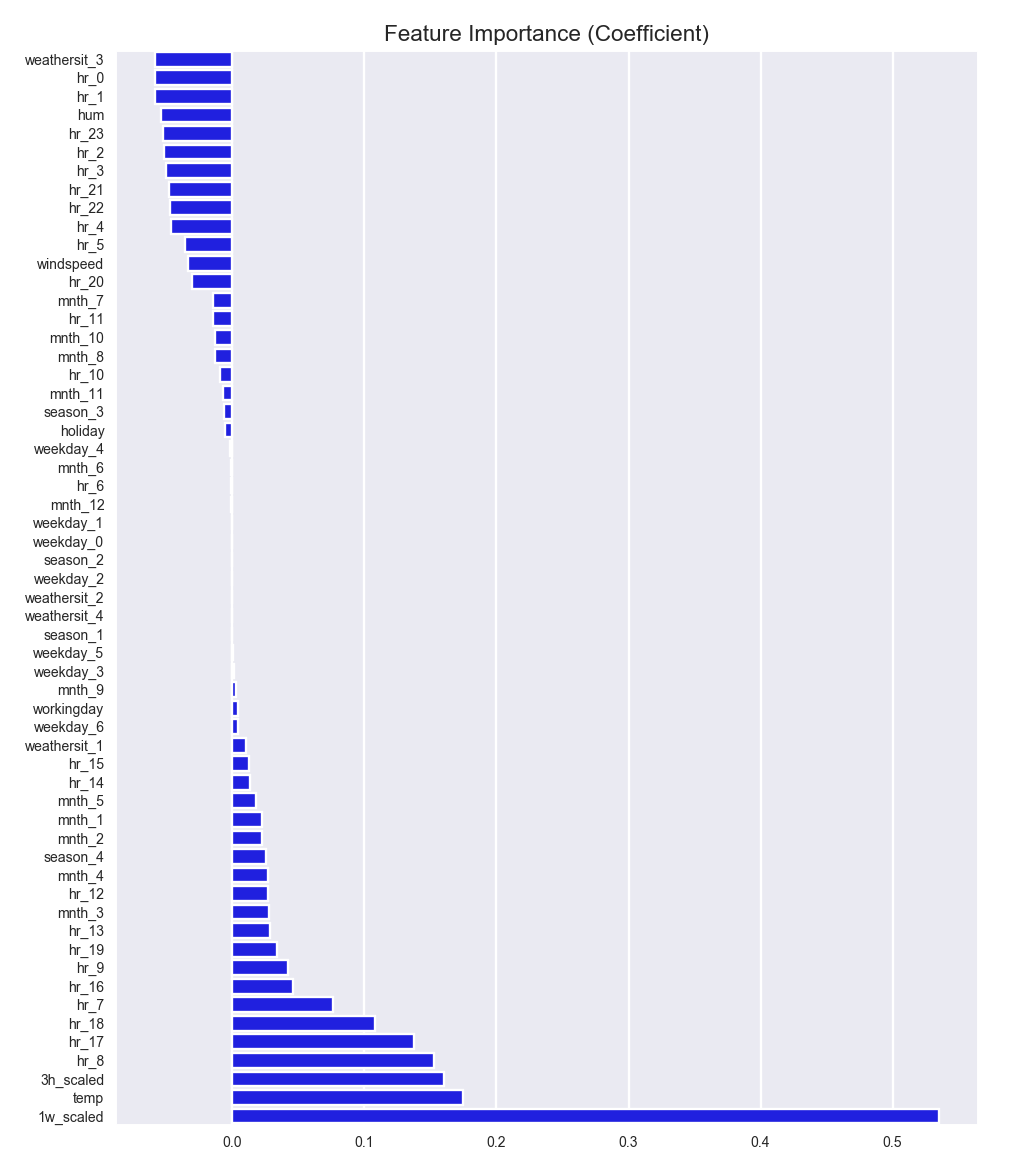

In [13]:
sns.set(style='darkgrid',context='talk',palette='Blues_r',font_scale=0.8)
sorted_coef_idx = clf_agg.best_estimator_.coef_.argsort()
coefficients =  clf_agg.best_estimator_.coef_
sorted_coef_index = coefficients.argsort()
feature_names = np.array(X_train.columns)
feature_names = feature_names[ sorted_coef_index ].astype('str')
n = 58
plt.figure(figsize=(9,0.18*n))
feat = feature_names[:]
coef = coefficients[sorted_coef_index][:]/np.sum(coefficients)
ax = sns.barplot(y=feat,x=coef,orient='h',color='Blue')
ax.axes.set_title("Feature Importance (Coefficient)")
ax.tick_params(labelsize=9,which='major',pad=-2)
plt.tight_layout()
#plt.savefig("./report/feature_importance.png",format='png')

# Model Export 

- The model has been exported into a file using pickle.
- A bunch of examples from the test data have been saved into the file *test_examples.csv* to be used as sample for inference of the model via http request to a flask application.

In [14]:
import pickle
pickle.dump(clf_agg, open('./model_export/elastic_regressor.pkl','wb'))

### App server

Navigate with a console to *model_export* folder, then run `python server_app.py`. 
This runs a Flask web application on the local browser, which allows to use the exported model file 

### Client

The model can be used for inference via simple HTTP POST requests: 

In [15]:
# generating a file with a list of test examples to predict
test_examples = X_test[-5:].to_csv("./model_export/test_examples.csv",header=False,index=False)

In [16]:
import requests
# url of flask web application
url = 'http://localhost:5000/elastic_regressor'

filename = "./model_export/test_examples.csv"
datafile = open(filename,"r")
files = {'files': (filename, datafile)}
#conduct a http post request to get model predictions 
r = requests.request("POST", url, files=files)
r.json()

{'predictions': [79.34411330441131,
  7.2598928844332775,
  -3.203011404592445,
  -0.6210003944978411,
  -20.046357926444642]}